<a href="https://colab.research.google.com/github/ShinwooChoi/ESAA-OB/blob/main/10_10_ESAA_OB_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

범위: <파이썬 머신러닝 완벽 가이드> 8장 p.566-583

### 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

### 개요
- Mercari Price Suggestion Challenge는 일본 온라인 쇼핑몰 **Mercari**의 상품 가격을 예측하는 과제  
- 제공 데이터는 상품명, 브랜드명, 카테고리, 제품 설명 등 텍스트 및 속성 데이터로 구성  
- 목표: 머신러닝 모델을 통해 입력된 상품 속성으로부터 판매자가 설정할 최적 가격 예측  

### 데이터 구성
- train_id: 데이터 id  
- name: 제품명  
- item_condition_id: 제품 상태  
- category_name: 카테고리명  
- brand_name: 브랜드명  
- price: 예측 대상 타깃 변수  
- shipping: 배송비 무료 여부 (1: 무료, 0: 유료)  
- item_description: 제품 설명  

### 데이터 로드 및 결측 확인
- 총 **1,482,535개 레코드**  
- `brand_name`: 약 849,853건만 존재, Null 많음  
- `category_name`: 약 63,000건 Null  
- `item_description`: 42건 Null (미미)  
- 결측치는 이후 `'Other_Null'`로 일괄 대체  

### 타깃 변수 처리
- `price`는 로그 변환 (`np.log1p`)을 적용해 정규 분포에 근접하도록 조정  
- 예측 모델의 학습 안정성 향상  

### 피처별 특성 요약
- **shipping**: 배송비 유무 (0: 유료 / 1: 무료)  
- **item_condition_id**: 1~5까지의 상태 값  
- **item_description**: ‘No description yet’ 존재 (의미 없음 → Null 처리 후 대체)  
- **category_name**: ‘/’ 기준으로 대·중·소분류(cat_dae, cat_jung, cat_so)로 분리  
- **brand_name, category_name, item_description**의 Null은 `'Other_Null'`로 변환  

### 피처 인코딩 및 벡터화
- 문자열 컬럼은 **원-핫 인코딩(LabelBinarizer)** 또는 **벡터화(Count / TF-IDF)** 적용  
- **brand_name, category_name, shipping, item_condition_id**: 원-핫 인코딩  
- **name**: CountVectorizer로 변환 (짧은 텍스트)  
- **item_description**: TfidfVectorizer로 변환 (긴 텍스트)  

### 피처 결합
- CountVectorizer, TfidfVectorizer 결과를 희소 행렬(csr_matrix) 형태로 결합  
- 추가 인코딩된 피처(cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id)를 함께 연결  
- `hstack()` 함수 사용하여 모든 희소 행렬 결합  

### 최종 데이터 구조
- 인코딩된 모든 피처를 결합한 데이터 타입: `csr_matrix`  
- shape: (1482535, 161569)  
- 메모리 절약을 위해 `gc.collect()`로 불필요한 객체 제거  

### 모델 구축 준비
- 결합된 데이터를 기반으로 회귀 모델을 통해 가격 예측 수행  
- 사용 평가 지표: **RMSLE (Root Mean Square Logarithmic Error)**  
- 로그 변환된 타깃을 사용하므로 RMSLE로 오차 측정  
- 값이 낮을수록 예측 성능이 우수함  


### 피처 인코딩 결과 및 데이터 결합

### 인코딩 데이터 타입 및 형태 확인
- 모든 범주형 피처를 **LabelBinarizer**로 원-핫 인코딩 수행  
- 인코딩 결과는 희소 행렬 형태(`csr_matrix`)  
- 피처 벡터화된 텍스트와 결합 시 차원이 크지만 희소 행렬 형태이므로 처리 가능  

### 희소 행렬 결합 (hstack)
- `hstack()`을 이용해 모든 인코딩 및 벡터화된 피처를 하나의 희소 행렬로 결합  
- 결합된 전체 데이터 shape: (1482535, 161569)  
- 메모리 절약을 위해 사용 후 `del` 및 `gc.collect()`로 객체 제거  

### 회귀 모델 구축 및 평가
- **Ridge 회귀**를 이용하여 price 예측 수행  
- 평가 지표: **RMSLE (Root Mean Square Logarithmic Error)**  
- 로그 변환된 타깃(`np.log1p`)을 사용했으므로, 예측값은 다시 지수 변환(`np.expm1`) 후 평가  

### RMSLE 계산 함수
- `rmsle(y, y_pred)`: 로그값 차이를 기반으로 평균 제곱근 오차 계산  
- `evaluate_org_price(y_test, preds)`: 로그값 복원 후 RMSLE 계산  

### 모델 학습 및 예측 함수
- `model_train_predict(model, matrix_list)`  
  - 입력: 회귀 모델 객체, 희소 행렬 리스트  

### Ridge 회귀 성능 비교
- Item Description 제외: RMSLE = 0.5021  
- Item Description 포함: RMSLE = 0.4712  
- → **Item Description 텍스트 피처의 영향이 매우 큼**을 확인  

### LightGBM 회귀 모델 적용
- LightGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156) 사용  
- 학습 및 예측 결과 RMSLE = 0.4565  
- Ridge보다 예측 성능이 우수  

### 앙상블(Ensemble) 적용
- Ridge(0.55 비율) + LightGBM(0.45 비율) 가중 평균  
- 최종 RMSLE = 0.4504  
- → 간단한 앙상블로 **예측 성능이 추가 향상**

### 요약
- 텍스트 및 범주형 데이터의 결합을 통한 회귀 모델 구축  
- Ridge → LightGBM → Ensemble 순으로 성능 개선  
- 텍스트 설명(`item_description`) 피처의 중요성 확인  
- 최종 모델은 RMSLE 0.45 수준으로 가격 예측 성능 달성  



In [52]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(290965, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,52.0,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"


In [53]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290965 entries, 0 to 290964
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           290965 non-null  int64  
 1   name               290965 non-null  object 
 2   item_condition_id  290965 non-null  int64  
 3   category_name      289701 non-null  object 
 4   brand_name         166665 non-null  object 
 5   price              290965 non-null  float64
 6   shipping           290965 non-null  int64  
 7   item_description   290965 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 17.8+ MB
None


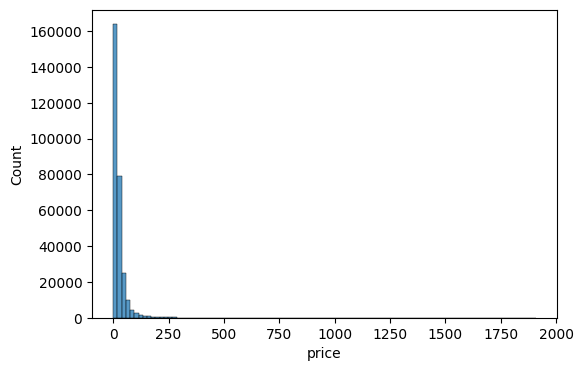

In [54]:
# Target 값인 price 칼럼의 데이터 분포도 살펴보기
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

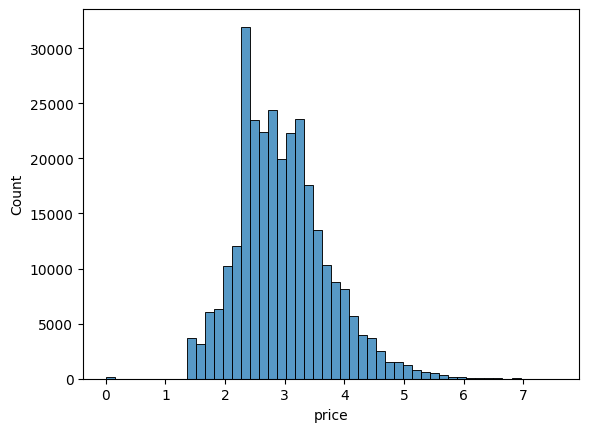

In [55]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [56]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [57]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    160957
1    130008
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    125449
3     84677
2     74130
4      6208
5       501
Name: count, dtype: int64


In [58]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

np.int64(16287)

In [59]:
# apply_lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대,중,소 칼럼을 mercadi_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] =\
zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     130457
Beauty                     40857
Kids                       33660
Electronics                24133
Men                        18512
Home                       13259
Vintage & Collectibles      9097
Other                       8885
Handmade                    5973
Sports & Outdoors           4868
Other_Null                  1264
Name: count, dtype: int64
중분류 개수: 114
소분류 개수: 781


In [60]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null값 건수 확인. 모두 0이 나와야 함
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


In [61]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 3014
brand name sample 5건: 
 brand_name
Other_Null           124300
PINK                  10678
Nike                  10414
Victoria's Secret      9465
LuLaRoe                6145
Name: count, dtype: int64


In [62]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name의 종류 개수: 263183
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [63]:
# item_description
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.54593851494167


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


In [64]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization Shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)


name vectorization Shape: (290965, 43967)
item_description vectorization shape: (290965, 50000)


In [65]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [65]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

In [66]:
from scipy.sparse import hstack
import gc

sparse_matrix_list=(X_name, X_descp, X_brand, X_item_cond_id, \
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse=hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

#데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (290965, 97893)


0

In [67]:
def rmsle(y, y_pred):
    #underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

    #원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요
    preds_exmpm=np.expm1(preds)
    y_test_exmpm=np.expm1(y_test)

    #rmsle로 RMSLE 값 추출
    rmsle_result=rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [68]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    #scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X=hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)

    #모델 학습 및 예측
    model.fit(X_train, y_train)
    preds=model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [69]:
linear_model=Ridge(solver= "lsqr", fit_intercept=False)

sparse_matrix_list=(X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test=model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list=(X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test=model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5153106385016885
Item Description을 포함한 rmsle 값: 0.49376919595934565


In [70]:
#from lightgbm import LGBMRegressor

#sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
#lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
#lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
#print('LightGBM rmsle 값: ', evaluate_org_price(y_test, lgbm_preds))

In [71]:
#preds = lgbm_preds * 0.45 + linear_preds * 0.55
#print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값: ', evaluate_org_price(y_test, preds))